In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import atomai as aoi
from sklearn import mixture
from sklearn.decomposition import PCA

from utilities import load_images_from_folder, crop_image, intensity_clipping, get_coordinates, get_training_data, gaussian, fitgaussian

In [2]:
images = load_images_from_folder("processed data")

Processing images: 100%|███████████████████████| 13/13 [00:00<00:00, 242.23it/s]


In [3]:
expdata = images[1]
training_data, training_coordinates = get_training_data(expdata,32)
training_coordinates[:,[1,0]] = training_coordinates[:,[0,1]]
d0, d1, d2 = training_data.shape

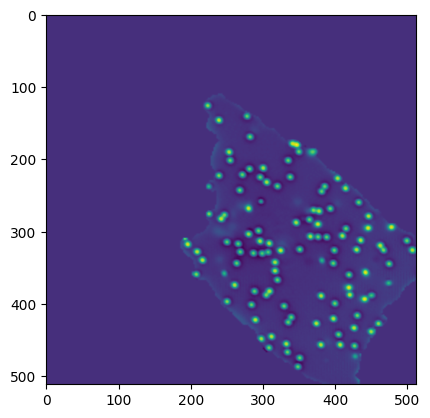

In [4]:
plt.imshow(expdata)

In [5]:
class_1_counts = []
class_2_counts = []

for i in range(0,100,1):
    window_size = 32
    n_components = 2
    covariance = 'diag'
    random_state = i
    clf = mixture.GaussianMixture(
        n_components = n_components,
        covariance_type = covariance,
        random_state = random_state)
    X_vec = training_data.reshape(d0,d1*d2)
    classes = clf.fit_predict(X_vec) +1
    cla = np.ndarray(shape=(
        np.amax(classes), int(window_size), int(window_size)))

    cl_all = []
    for i in range(np.amax(classes)):
        cl = training_data[classes == i + 1]
        cl_all.append(cl)
        cla[i] = np.mean(cl, axis=0)

    class_1_counts.append(len(cl_all[0]))
    class_2_counts.append(len(cl_all[1]))

class_1_counts = np.array(class_1_counts)
class_2_counts = np.array(class_2_counts)
possible_distributions = np.concatenate((class_1_counts,class_2_counts))

In [6]:
most_frequent_distribution = np.bincount(possible_distributions).argmax()
if most_frequent_distribution in class_1_counts:
    random_state_choice = np.where(class_1_counts == most_frequent_distribution)[0][0]
else:
    random_state_choice = np.where(class_2_counts == most_frequent_distribution)[0][0]


GMM components


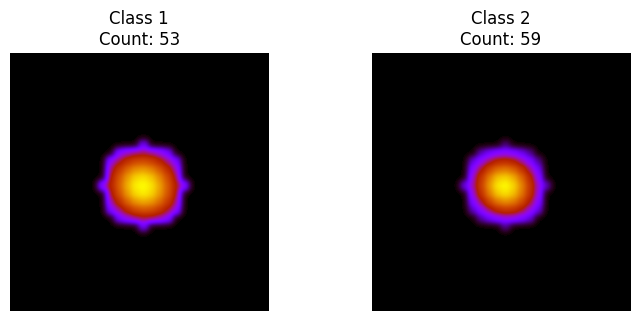

In [7]:
window_size = 32
n_components = 2
covariance = 'diag'
random_state = random_state_choice
clf = mixture.GaussianMixture(
    n_components = n_components,
    covariance_type = covariance,
    random_state = random_state)
X_vec = training_data.reshape(d0,d1*d2)
classes = clf.fit_predict(X_vec) +1
cla = np.ndarray(shape=(
    np.amax(classes), int(window_size), int(window_size)))

rows = int(np.ceil(float(n_components)/5))
cols = int(np.ceil(float(np.amax(classes))/rows))
fig = plt.figure(figsize=(4*cols, 4*(1+rows//2)))
gs = gridspec.GridSpec(rows, cols)
print('\nGMM components')

cl_all = []
for i in range(np.amax(classes)):
    cl = training_data[classes == i + 1]
    cl_all.append(cl)
    cla[i] = np.mean(cl, axis=0)
    ax = fig.add_subplot(gs[i])
    ax.imshow(cla[i, :, :], cmap='gnuplot',
            interpolation='Gaussian')
    ax.axis('off')
    ax.set_title('Class '+str(i+1)+'\nCount: '+str(len(cl)))

plt.subplots_adjust(hspace=0.6, wspace=0.4)
plt.show()

In [8]:
probs = clf.predict_proba(X_vec)

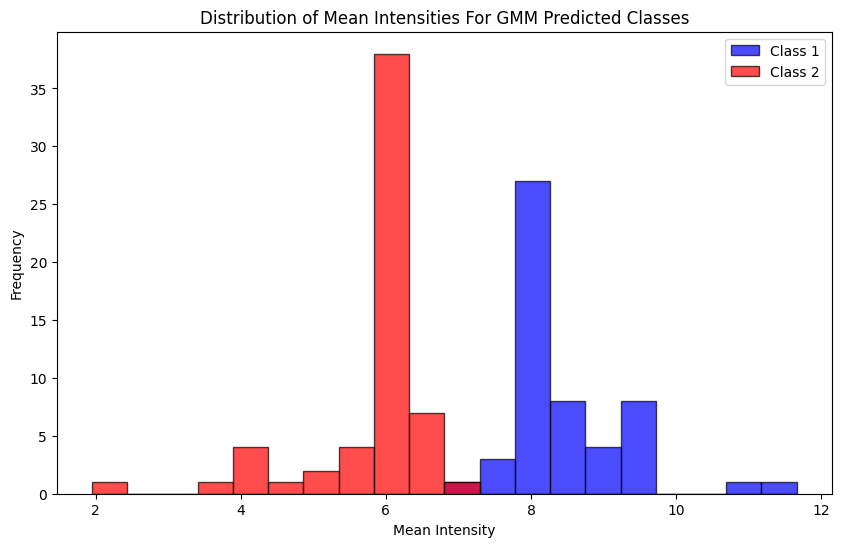

In [9]:
class_labels = np.unique(classes)

class_1_indices = np.where(classes == class_labels[0])
class_2_indices = np.where(classes == class_labels[1])

class_1_average_intensities = np.mean(training_data[class_1_indices], axis = (1,2))
class_2_average_intensities = np.mean(training_data[class_2_indices], axis = (1,2))

all_intensities = np.concatenate([class_1_average_intensities, class_2_average_intensities])
bins = np.histogram_bin_edges(all_intensities, bins=20)

plt.figure(figsize=(10, 6))
plt.hist(class_1_average_intensities, bins=bins, alpha=0.7, label='Class 1', color='blue', edgecolor='black')
plt.hist(class_2_average_intensities, bins=bins, alpha=0.7, label='Class 2', color='red', edgecolor='black')
plt.title('Distribution of Mean Intensities For GMM Predicted Classes')
plt.xlabel('Mean Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

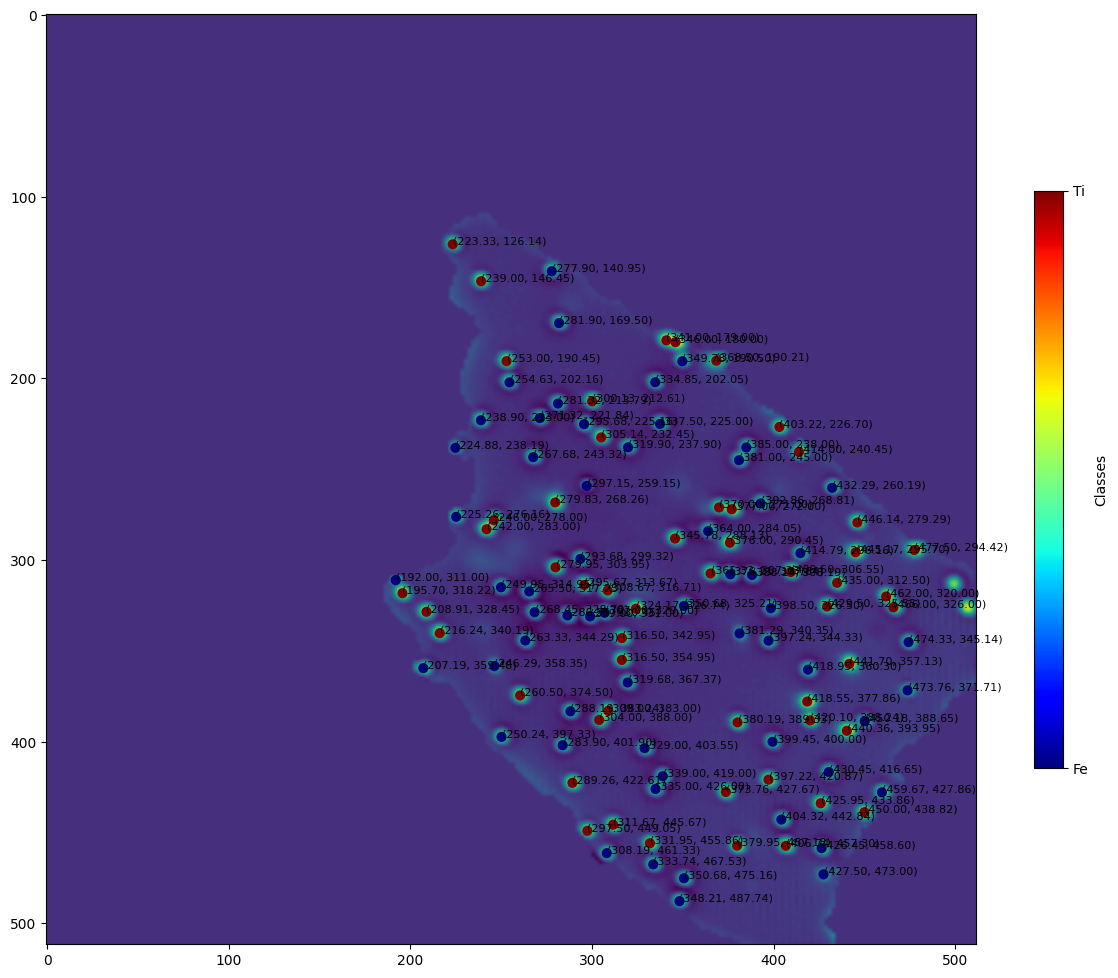

In [10]:
atom_classes = classes.astype(object)
if np.min(class_1_average_intensities) < np.min(class_2_average_intensities):
    atom_classes[atom_classes == 1] = "Fe"
    atom_classes[atom_classes == 2] = "Ti"

else:
    atom_classes[atom_classes == 2] = "Fe"
    atom_classes[atom_classes == 1] = "Ti"

class_labels, class_numeric = np.unique(atom_classes, return_inverse=True)

plt.figure(figsize=(15, 15))
sc = plt.scatter(training_coordinates[:, 0], training_coordinates[:, 1], c=class_numeric, s=40,
            cmap="jet")
im = plt.imshow(expdata)
cbar = plt.colorbar(sc, shrink=0.5, label="Classes")
cbar.set_ticks(np.arange(len(class_labels)))
cbar.set_ticklabels(class_labels)
for i, coord in enumerate(training_coordinates):
    plt.text(coord[0], coord[1], f'({coord[0]:.2f}, {coord[1]:.2f})', fontsize=8, color='black')
plt.show()

In [19]:
Fe_indices = np.where(class_numeric == 0)[0]
Ti_indices = np.where(class_numeric == 1)[0]

Fe_data = training_data[Fe_indices]
Ti_data = training_data[Ti_indices]

Fe_coordinates = training_coordinates[Fe_indices]
Ti_coordinates = training_coordinates[Ti_indices]

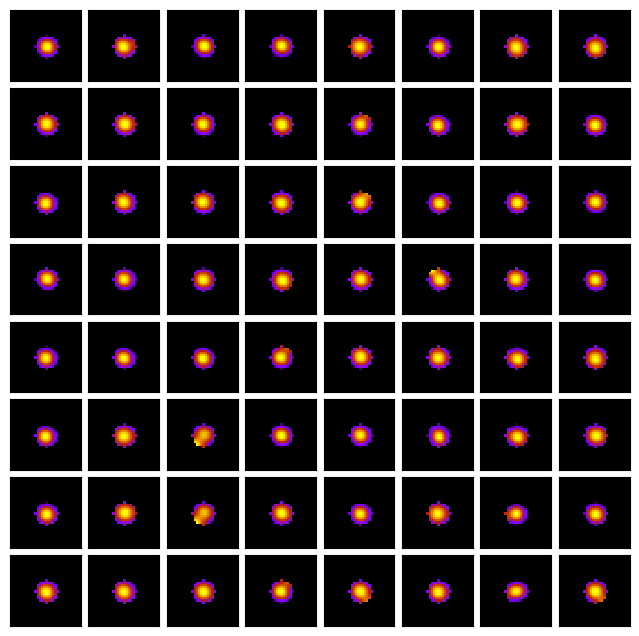

In [13]:
# Visulaizing the training dataset
np.random.seed(15)  # fix seed so that we get the same samples displayed at every run
fig, axes = plt.subplots(8, 8, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = np.random.randint(len(training_data))
    ax.imshow(training_data[i], cmap='gnuplot', interpolation='nearest')

In [14]:
# Training the rVAE with tuned parameters on the subimages generated 
in_dim = (window_size, window_size)   # Input dimensions of the dataset

rvae_mgo = aoi.models.rVAE(in_dim, nb_classes=2,
                           numhidden_encoder = 512, numhidden_decoder = 512, skip = True)

rvae_mgo.fit(training_data, class_numeric, training_cycles=100, batch_size=5)

Epoch: 1/100, Training loss: 393163.6903
Epoch: 2/100, Training loss: 384810.7926
Epoch: 3/100, Training loss: 385424.4574
Epoch: 4/100, Training loss: 381785.8345
Epoch: 5/100, Training loss: 371996.2195
Epoch: 6/100, Training loss: 360469.2053
Epoch: 7/100, Training loss: 347410.2244
Epoch: 8/100, Training loss: 334233.0092
Epoch: 9/100, Training loss: 322287.6001
Epoch: 10/100, Training loss: 309032.8018
Epoch: 11/100, Training loss: 293877.9801
Epoch: 12/100, Training loss: 276713.5064
Epoch: 13/100, Training loss: 260188.2337
Epoch: 14/100, Training loss: 246786.3601
Epoch: 15/100, Training loss: 229125.2188
Epoch: 16/100, Training loss: 213082.5064
Epoch: 17/100, Training loss: 199158.6758
Epoch: 18/100, Training loss: 181926.7798
Epoch: 19/100, Training loss: 169442.9680
Epoch: 20/100, Training loss: 156205.9059
Epoch: 21/100, Training loss: 145062.1875
Epoch: 22/100, Training loss: 131372.5465
Epoch: 23/100, Training loss: 122235.9996
Epoch: 24/100, Training loss: 112418.0323
E

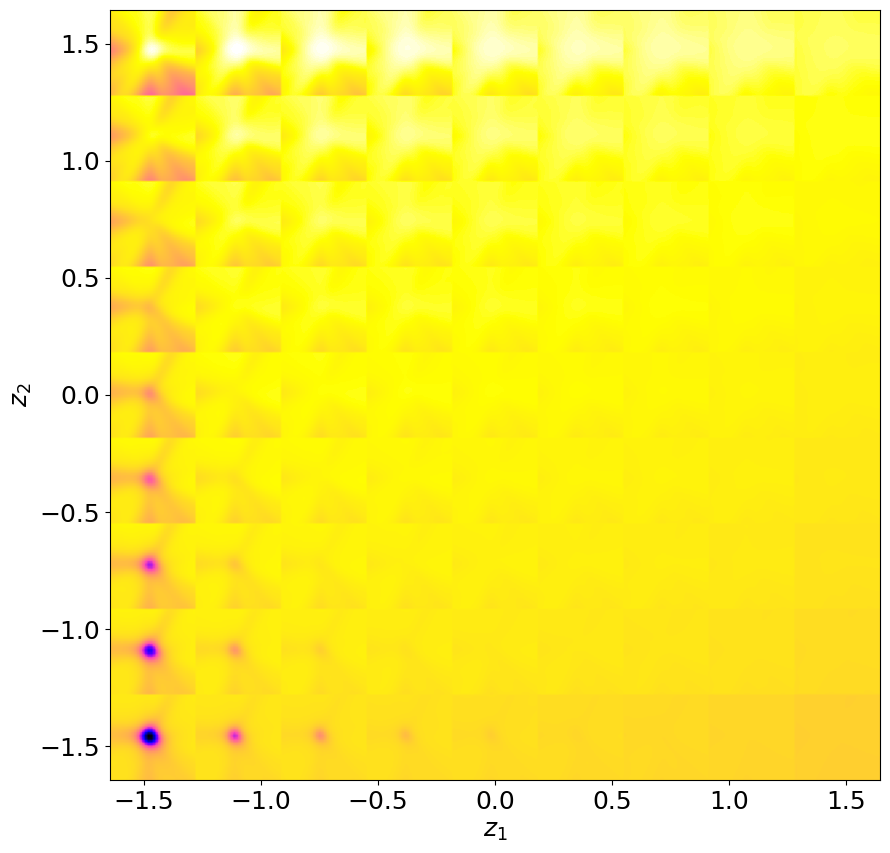

array([[0.88470619, 0.89148053, 0.89906711, ..., 0.93876737, 0.93881811,
        0.93880712],
       [0.87836847, 0.88423805, 0.89131167, ..., 0.93906752, 0.93906793,
        0.93900846],
       [0.87290149, 0.87770521, 0.88388385, ..., 0.93948483, 0.9394585 ,
        0.93939022],
       ...,
       [0.86105485, 0.86138426, 0.86143164, ..., 0.82665461, 0.82690827,
        0.82710356],
       [0.86030878, 0.86064958, 0.8607126 , ..., 0.82628323, 0.82657984,
        0.82683984],
       [0.85954409, 0.85983891, 0.86008017, ..., 0.82588362, 0.82618846,
        0.82649944]])

In [15]:
rvae_mgo.manifold2d(label=1, origin="upper", cmap="gnuplot2")

In [16]:
z_mean, z_sd = rvae_mgo.encode(training_data)   # Encoding the full input dataset

z1, z2, z3 = z_mean[:,0], z_mean[:, 1:3], z_mean[:, 3:]

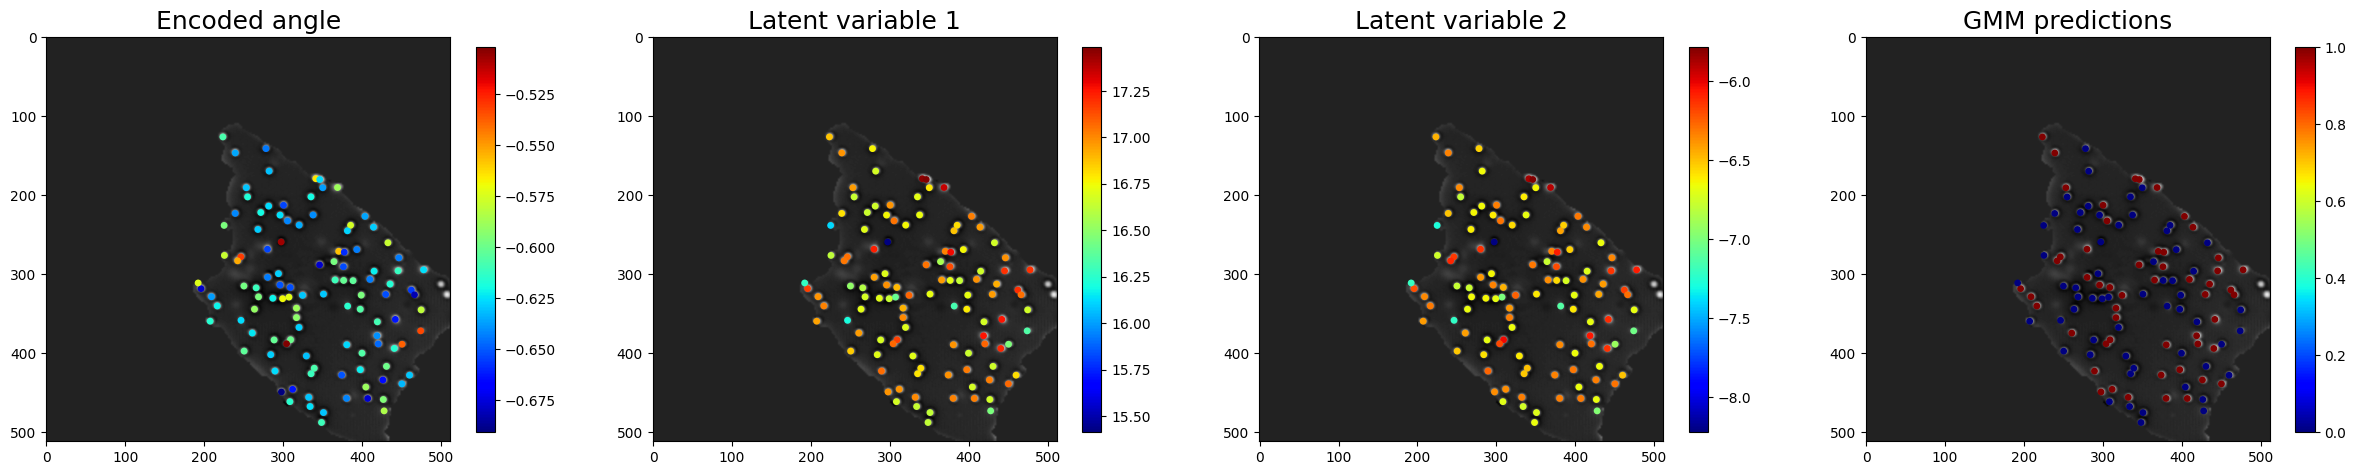

In [17]:
fig, ax = plt.subplots(1, 4, figsize=(30, 10))
im0 = ax[0].imshow(expdata, cmap="gray")
sc0 = ax[0].scatter(training_coordinates[:, 0], training_coordinates[:, 1], c=z1, s=15,
                cmap="jet")
ax[0].set_title("Encoded angle", fontsize=18)
fig.colorbar(sc0, ax=ax[0], shrink=.5)

im1 = ax[1].imshow(expdata, cmap="gray")
sc1 = ax[1].scatter(training_coordinates[:, 0], training_coordinates[:, 1], c=z3[:,0], s=15,
                cmap="jet")
ax[1].set_title("Latent variable 1", fontsize=18)
fig.colorbar(sc1, ax=ax[1], shrink=.5)

im2 = ax[2].imshow(expdata, cmap="gray")
sc2 = ax[2].scatter(training_coordinates[:, 0], training_coordinates[:, 1], c=z3[:,1], s=15,
                cmap="jet")
ax[2].set_title("Latent variable 2", fontsize=18)
fig.colorbar(sc2, ax=ax[2], shrink=.5)

im3 = ax[3].imshow(expdata, cmap="gray")
sc3 = ax[3].scatter(training_coordinates[:, 0], training_coordinates[:, 1], c=class_numeric, s=15,
                cmap="jet")
ax[3].set_title("GMM predictions", fontsize=18)
fig.colorbar(sc3, ax=ax[3], shrink=.5)

plt.show()

In [18]:
z_mean_Fe, z_sd_Fe = rvae_mgo.encode(Fe_data)   # Encoding the full input dataset

z1_Fe, z2_Fe, z3_Fe = z_mean_Fe[:,0], z_mean_Fe[:, 1:3], z_mean_Fe[:, 3:]

NameError: name 'Fe_data' is not defined

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10))
im0 = ax[0].imshow(expdata, cmap="gray")
sc0 = ax[0].scatter(Fe_coordinates[:, 0], Fe_coordinates[:, 1], c=z1_Fe, s=15,
                cmap="jet")
ax[0].set_title("Encoded angle", fontsize=18)
fig.colorbar(sc0, ax=ax[0], shrink=.5)

im1 = ax[1].imshow(expdata, cmap="gray")
sc1 = ax[1].scatter(Fe_coordinates[:, 0], Fe_coordinates[:, 1], c=z3_Fe[:,0], s=15,
                cmap="jet")
ax[1].set_title("Latent variable 1", fontsize=18)
fig.colorbar(sc1, ax=ax[1], shrink=.5)

im2 = ax[2].imshow(expdata, cmap="gray")
sc2 = ax[2].scatter(Fe_coordinates[:, 0], Fe_coordinates[:, 1], c=z3_Fe[:,1], s=15,
                cmap="jet")
ax[2].set_title("Latent variable 2", fontsize=18)
fig.colorbar(sc2, ax=ax[2], shrink=.5)

plt.show()

In [ ]:
fig, (ax1) = plt.subplots(1, 1, figsize =(15, 6))
im1 = ax1.scatter(z3_Fe[:,0],z3_Fe[:,1])
ax1.set_xlabel("Latent variable 1", fontsize=14)
ax1.set_ylabel("Latent variable 2", fontsize=14)
ax1.set_title('Latent space')

In [ ]:
pixel_values = []
mean_intensity = []
min_intensity = []
max_intensity = []

for i, data in enumerate(Fe_data):
    
    pixel_values.append(Fe_data[i][16][16])
    mean_intensity.append(np.mean(data))

    min_intensity.append(np.min(data))
    max_intensity.append(np.max(data))

In [ ]:
from scipy.spatial import distance_matrix

nearest_neighbour = []
n_nearest_neighbours = []

Fe_indices = np.where(class_numeric == 0)[0]

dist_matrix = distance_matrix(training_coordinates,training_coordinates)
np.fill_diagonal(dist_matrix, np.inf)
dist_matrix = dist_matrix[Fe_indices, :]
nearest_indices = np.argmin(dist_matrix, axis=1)
for j, index in enumerate(nearest_indices):
    nearest_neighbour.append(dist_matrix[j][index])
for j in range (len(dist_matrix)):
    n = 0
    for k in dist_matrix[j]:
        if k<12:
            n = n+1
    n_nearest_neighbours.append(n)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 6))
im1 = ax1.scatter(z3_Fe[:,0],z3_Fe[:,1], c = np.array(min_intensity), s=1, cmap='jet')
ax1.set_xlabel("Latent variable 1", fontsize=14)
ax1.set_ylabel("Latent variable 2", fontsize=14)
ax1.set_title('Latent space by Min Intensity')
fig.colorbar(im1, ax=ax1)

im2 = ax2.scatter(z3_Fe[:,0],z3_Fe[:,1], c = np.array(max_intensity), s=1, cmap='jet')
ax2.set_xlabel("Latent variable 1", fontsize=14)
ax2.set_ylabel("Latent variable 2", fontsize=14)
ax2.set_title('Latent space by Max Intensity')
fig.colorbar(im2, ax=ax2)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 6))
im1 = ax1.scatter(z3_Fe[:,0],z3_Fe[:,1], c = np.array(pixel_values), s=1, cmap='jet')
ax1.set_xlabel("Latent variable 1", fontsize=14)
ax1.set_ylabel("Latent variable 2", fontsize=14)
ax1.set_title('Latent space by Coordinate Intensity')
fig.colorbar(im1, ax=ax1)

im2 = ax2.scatter(z3_Fe[:,0],z3_Fe[:,1], c = np.array(mean_intensity), s=1, cmap='jet')
ax2.set_xlabel("Latent variable 1", fontsize=14)
ax2.set_ylabel("Latent variable 2", fontsize=14)
ax2.set_title('Latent space by Mean Intensity')
fig.colorbar(im2, ax=ax2)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 6))
im1 = ax1.scatter(z3_Fe[:,0],z3_Fe[:,1], c = np.array(nearest_neighbour), s=1, cmap='jet')
ax1.set_xlabel("Latent variable 1", fontsize=14)
ax1.set_ylabel("Latent variable 2", fontsize=14)
ax1.set_title('Latent space by Distance to Nearest Neighbour')
fig.colorbar(im1, ax=ax1)

im2 = ax2.scatter(z3_Fe[:,0],z3_Fe[:,1], c = np.array(n_nearest_neighbours), s=1, cmap='jet')
ax2.set_xlabel("Latent variable 1", fontsize=14)
ax2.set_ylabel("Latent variable 2", fontsize=14)
ax2.set_title('Latent space by Number of Nearest Neighbours')
fig.colorbar(im2, ax=ax2)

In [ ]:
z_mean_Ti, z_sd_Ti = rvae_mgo.encode(Ti_data)   # Encoding the full input dataset

z1_Ti, z2_Ti, z3_Ti = z_mean_Ti[:,0], z_mean_Ti[:, 1:3], z_mean_Ti[:, 3:]

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10))
im0 = ax[0].imshow(expdata, cmap="gray")
sc0 = ax[0].scatter(Ti_coordinates[:, 0], Ti_coordinates[:, 1], c=z1_Ti, s=15,
                cmap="jet")
ax[0].set_title("Encoded angle", fontsize=18)
fig.colorbar(sc0, ax=ax[0], shrink=.5)

im1 = ax[1].imshow(expdata, cmap="gray")
sc1 = ax[1].scatter(Ti_coordinates[:, 0], Ti_coordinates[:, 1], c=z3_Ti[:,0], s=15,
                cmap="jet")
ax[1].set_title("Latent variable 1", fontsize=18)
fig.colorbar(sc1, ax=ax[1], shrink=.5)

im2 = ax[2].imshow(expdata, cmap="gray")
sc2 = ax[2].scatter(Ti_coordinates[:, 0], Ti_coordinates[:, 1], c=z3_Ti[:,1], s=15,
                cmap="jet")
ax[2].set_title("Latent variable 2", fontsize=18)
fig.colorbar(sc2, ax=ax[2], shrink=.5)

plt.show()

In [ ]:
fig, (ax1) = plt.subplots(1, 1, figsize =(15, 6))
im1 = ax1.scatter(z3_Ti[:,0],z3_Ti[:,1])
ax1.set_xlabel("Latent variable 1", fontsize=14)
ax1.set_ylabel("Latent variable 2", fontsize=14)
ax1.set_title('Latent space')

In [ ]:
pixel_values = []
mean_intensity = []
min_intensity = []
max_intensity = []

for i, data in enumerate(Ti_data):
    
    pixel_values.append(Ti_data[i][16][16])
    mean_intensity.append(np.mean(data))

    min_intensity.append(np.min(data))
    max_intensity.append(np.max(data))

In [ ]:
from scipy.spatial import distance_matrix

nearest_neighbour = []
n_nearest_neighbours = []

Ti_indices = np.where(class_numeric == 1)[0]

dist_matrix = distance_matrix(training_coordinates,training_coordinates)
np.fill_diagonal(dist_matrix, np.inf)
dist_matrix = dist_matrix[Ti_indices, :]
nearest_indices = np.argmin(dist_matrix, axis=1)
for j, index in enumerate(nearest_indices):
    nearest_neighbour.append(dist_matrix[j][index])
for j in range (len(dist_matrix)):
    n = 0
    for k in dist_matrix[j]:
        if k<12:
            n = n+1
    n_nearest_neighbours.append(n)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 6))
im1 = ax1.scatter(z3_Ti[:,0],z3_Ti[:,1], c = np.array(min_intensity), s=1, cmap='jet')
ax1.set_xlabel("Latent variable 1", fontsize=14)
ax1.set_ylabel("Latent variable 2", fontsize=14)
ax1.set_title('Latent space by Min Intensity')
fig.colorbar(im1, ax=ax1)

im2 = ax2.scatter(z3_Ti[:,0],z3_Ti[:,1], c = np.array(max_intensity), s=1, cmap='jet')
ax2.set_xlabel("Latent variable 1", fontsize=14)
ax2.set_ylabel("Latent variable 2", fontsize=14)
ax2.set_title('Latent space by Max Intensity')
fig.colorbar(im2, ax=ax2)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 6))
im1 = ax1.scatter(z3_Ti[:,0],z3_Ti[:,1], c = np.array(pixel_values), s=1, cmap='jet')
ax1.set_xlabel("Latent variable 1", fontsize=14)
ax1.set_ylabel("Latent variable 2", fontsize=14)
ax1.set_title('Latent space by Coordinate Intensity')
fig.colorbar(im1, ax=ax1)

im2 = ax2.scatter(z3_Ti[:,0],z3_Ti[:,1], c = np.array(mean_intensity), s=1, cmap='jet')
ax2.set_xlabel("Latent variable 1", fontsize=14)
ax2.set_ylabel("Latent variable 2", fontsize=14)
ax2.set_title('Latent space by Mean Intensity')
fig.colorbar(im2, ax=ax2)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 6))
im1 = ax1.scatter(z3_Ti[:,0],z3_Ti[:,1], c = np.array(nearest_neighbour), s=1, cmap='jet')
ax1.set_xlabel("Latent variable 1", fontsize=14)
ax1.set_ylabel("Latent variable 2", fontsize=14)
ax1.set_title('Latent space by Distance to Nearest Neighbour')
fig.colorbar(im1, ax=ax1)

im2 = ax2.scatter(z3_Ti[:,0],z3_Ti[:,1], c = np.array(n_nearest_neighbours), s=1, cmap='jet')
ax2.set_xlabel("Latent variable 1", fontsize=14)
ax2.set_ylabel("Latent variable 2", fontsize=14)
ax2.set_title('Latent space by Number of Nearest Neighbours')
fig.colorbar(im2, ax=ax2)